In [1]:
# =========================
# 1️⃣ Setup & Imports
# =========================
import pandas as pd
import numpy as np

# Sklearn tools
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.multioutput import MultiOutputClassifier

# Optional baseline models
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
import lightgbm as lgb

# PyTorch (if needed later)
import torch

# TabTransformer (not using now, but keeping for reference)
try:
    from pytorch_tabular import TabularModel
    from pytorch_tabular.config import DataConfig, ModelConfig, TrainerConfig
except:
    pass

# Explainability
import shap

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Zip handling / file uploads
from zipfile import ZipFile
import os
try:
    from google.colab import files
except:
    pass

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)


In [2]:
# =========================
# Upload all ZIPs at once
# =========================
print("Upload all three ZIP files (Diabetes, Heart, Stroke) at once:")
uploaded = files.upload()  # Select all 3 ZIPs together

# =========================
# Extract and load each CSV
# =========================

# Create folders
os.makedirs('diabetes_data', exist_ok=True)
os.makedirs('heart_data', exist_ok=True)
os.makedirs('stroke_data', exist_ok=True)

# Map ZIP filenames to output folders and expected CSV names
zip_map = {
    'archive.zip': ('diabetes_data', 'diabetes.csv'),
    'archive (2).zip': ('heart_data', 'heart_disease_data.csv'),
    'archive (1).zip': ('stroke_data', 'healthcare-dataset-stroke-data.csv')
}

# Extract and read
for zip_name, (folder, csv_name) in zip_map.items():
    if zip_name in uploaded:
        with ZipFile(zip_name, 'r') as zip_ref:
            zip_ref.extractall(folder)
        if os.path.exists(f"{folder}/{csv_name}"):
            if 'diabetes' in csv_name.lower():
                diabetes_df = pd.read_csv(f"{folder}/{csv_name}")
            elif 'heart' in csv_name.lower():
                heart_df = pd.read_csv(f"{folder}/{csv_name}")
            elif 'stroke' in csv_name.lower():
                stroke_df = pd.read_csv(f"{folder}/{csv_name}")
        else:
            print(f"CSV {csv_name} not found in {zip_name}")
    else:
        print(f"{zip_name} not uploaded!")

Upload all three ZIP files (Diabetes, Heart, Stroke) at once:


Saving archive (2).zip to archive (2).zip
Saving archive (1).zip to archive (1).zip
Saving archive.zip to archive.zip


In [3]:
# =========================
# 1️⃣ Add target columns
# =========================
diabetes_df['Diabetes'] = diabetes_df['Outcome']
diabetes_df.drop(['Outcome'], axis=1, inplace=True)

heart_df['HeartDisease'] = heart_df['target']
heart_df.drop(['target'], axis=1, inplace=True)

stroke_df['Stroke'] = stroke_df['stroke']
stroke_df.drop(['stroke'], axis=1, inplace=True)  # ✅ Drop duplicate column

# =========================
# 2️⃣ Align features
# =========================
common_features = ['age', 'bmi', 'hypertension', 'heart_disease',
                   'avg_glucose_level', 'smoking_status', 'gender']

for col in common_features:
    if col not in diabetes_df.columns:
        diabetes_df[col] = np.nan
    if col not in heart_df.columns:
        heart_df[col] = np.nan
    if col not in stroke_df.columns:
        stroke_df[col] = np.nan

# =========================
# 3️⃣ Handle missing values
# =========================
for df in [diabetes_df, heart_df, stroke_df]:
    for col in df.columns:
        if df[col].dtype in ['float64', 'int64']:
            df[col].fillna(df[col].median(), inplace=True)
        else:
            df[col].fillna(df[col].mode()[0], inplace=True)

# =========================
# 4️⃣ Merge datasets
# =========================
full_df = pd.concat([diabetes_df, heart_df, stroke_df], axis=0, ignore_index=True)

# =========================
# 5️⃣ Define features & targets
# =========================
features = [col for col in full_df.columns if col not in ['Diabetes', 'HeartDisease', 'Stroke']]
target = ['Diabetes', 'HeartDisease', 'Stroke']

X = full_df[features]
y = full_df[target]

print("Merged dataset shape:", full_df.shape)
print("Features:", features)
print("Targets:", target)


Merged dataset shape: (6484, 34)
Features: ['Pregnancies', 'Glucose', 'BloodPressure', 'SkinThickness', 'Insulin', 'BMI', 'DiabetesPedigreeFunction', 'Age', 'age', 'bmi', 'hypertension', 'heart_disease', 'avg_glucose_level', 'smoking_status', 'gender', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'id', 'ever_married', 'work_type', 'Residence_type']
Targets: ['Diabetes', 'HeartDisease', 'Stroke']


/tmp/ipython-input-8258115.py:33: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/tmp/ipython-input-8258115.py:35: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'd

In [4]:
# =========================
# Preprocessing
# =========================

# Copy X to avoid modifying original
X_processed = X.copy()

# Identify categorical columns
categorical_cols = X_processed.select_dtypes(include='object').columns.tolist()
print("Categorical columns:", categorical_cols)

# Encode categorical columns
for col in categorical_cols:
    le = LabelEncoder()
    X_processed[col] = le.fit_transform(X_processed[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_processed, y, test_size=0.2, random_state=42
)

# Scale numeric features only
numeric_cols = X_train.select_dtypes(include=['float64','int64']).columns
scaler = StandardScaler()

X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols] = scaler.transform(X_test[numeric_cols])

print("Preprocessing done. Ready for modeling!")


Categorical columns: ['smoking_status', 'gender', 'ever_married', 'work_type', 'Residence_type']
Preprocessing done. Ready for modeling!


/tmp/ipython-input-3504668763.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[-0.64121577  1.45235506 -1.33907271 ...  0.05664117 -0.64121577
  1.45235506]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
/tmp/ipython-input-3504668763.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.04228808  1.79707427  0.04228808 ... -0.83510501 -0.83510501
  1.79707427]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  X_train.loc[:, numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
/tmp/ipython-input-3504668763.py:26: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 0.09551193  1.5398862  -1.34886234 ... -1.348

In [5]:
from sklearn.impute import SimpleImputer

# Imputer for all numeric columns (median)
num_imputer = SimpleImputer(strategy='median')

X_train.loc[:, numeric_cols] = num_imputer.fit_transform(X_train[numeric_cols])
X_test.loc[:, numeric_cols] = num_imputer.transform(X_test[numeric_cols])

# Check for missing values
print("Missing values after imputation (train):")
print(X_train.isna().sum())
print("Missing values after imputation (test):")
print(X_test.isna().sum())


Missing values after imputation (train):
Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
age                         0
bmi                         0
hypertension                0
heart_disease               0
avg_glucose_level           0
smoking_status              0
gender                      0
sex                         0
cp                          0
trestbps                    0
chol                        0
fbs                         0
restecg                     0
thalach                     0
exang                       0
oldpeak                     0
slope                       0
ca                          0
thal                        0
id                          0
ever_married                0
work_type                   0
Residence_type              0
dtype: int64
Missing values a

In [7]:
# Ensure targets are integers
y_train = y_train.fillna(0).astype(int)
y_test = y_test.fillna(0).astype(int)

# Base classifier
base_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# Multi-output model
multi_clf = MultiOutputClassifier(base_clf)
multi_clf.fit(X_train, y_train)

# Predictions
y_pred = multi_clf.predict(X_test)

# Evaluate
for i, disease in enumerate(y_train.columns):
    print(f"\n=== {disease} ===")
    print(classification_report(y_test[disease], y_pred[:, i]))
    print("Accuracy:", accuracy_score(y_test[disease], y_pred[:, i]))



=== Diabetes ===
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      1231
           1       0.52      0.97      0.68        66

    accuracy                           0.95      1297
   macro avg       0.76      0.96      0.83      1297
weighted avg       0.97      0.95      0.96      1297

Accuracy: 0.9529683885890516

=== HeartDisease ===
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      1232
           1       0.77      1.00      0.87        65

    accuracy                           0.99      1297
   macro avg       0.89      0.99      0.93      1297
weighted avg       0.99      0.99      0.99      1297

Accuracy: 0.9853508095605242

=== Stroke ===
              precision    recall  f1-score   support

           0       0.97      0.92      0.94      1237
           1       0.18      0.37      0.24        60

    accuracy                           0.89      1297
   macro avg  


=== SHAP Summary for Diabetes ===


/tmp/ipython-input-1112535397.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_to_plot, X_test, feature_names=X_test.columns, show=True)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


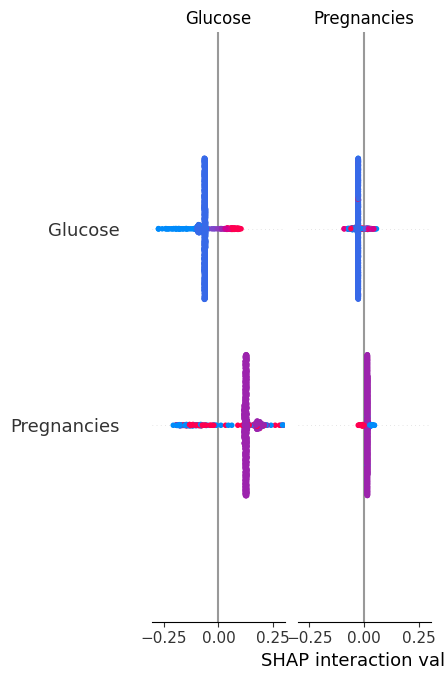


=== SHAP Summary for HeartDisease ===


/tmp/ipython-input-1112535397.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_to_plot, X_test, feature_names=X_test.columns, show=True)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


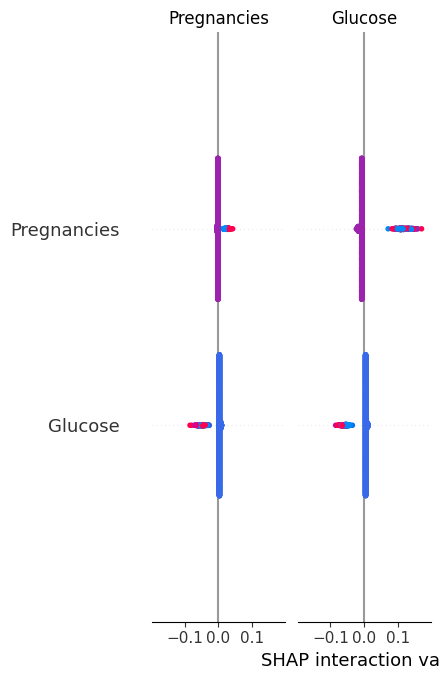


=== SHAP Summary for Stroke ===


/tmp/ipython-input-1112535397.py:20: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals_to_plot, X_test, feature_names=X_test.columns, show=True)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


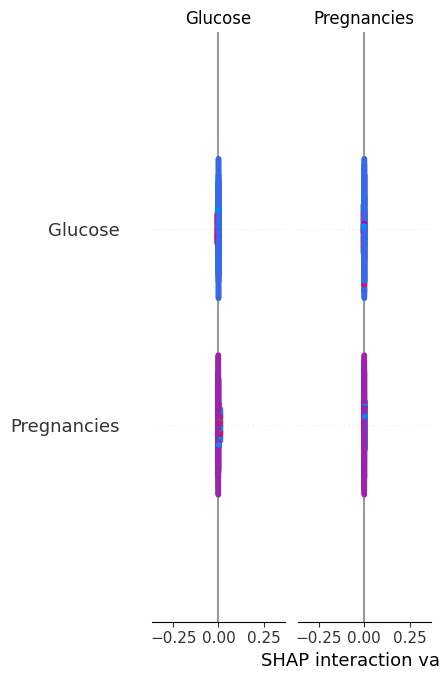

In [8]:
import shap

# Create a TreeExplainer for each disease model
for i, disease in enumerate(y_train.columns):
    print(f"\n=== SHAP Summary for {disease} ===")

    # Explainer for the i-th disease
    explainer = shap.TreeExplainer(multi_clf.estimators_[i])

    # Compute SHAP values
    shap_values = explainer.shap_values(X_test)

    # If it's binary classification, pick class 1
    if isinstance(shap_values, list) and len(shap_values) == 2:
        shap_vals_to_plot = shap_values[1]
    else:
        shap_vals_to_plot = shap_values

    # Plot summary
    shap.summary_plot(shap_vals_to_plot, X_test, feature_names=X_test.columns, show=True)


In [10]:
def predict_diseases_safe(input_df):
    """
    input_df: pd.DataFrame with same features as training set
    returns: predicted classes and probabilities for all three diseases
    """
    df = input_df.copy()

    # Encode categorical columns using fitted encoders
    for col in categorical_cols:
        if col in df.columns:
            le = encoders[col]
            # Map unseen labels to -1
            df[col] = df[col].apply(lambda x: x if x in le.classes_ else -1)

            # Temporarily extend classes_ to include -1
            if -1 not in le.classes_:
                le.classes_ = np.append(le.classes_, -1)

            df[col] = le.transform(df[col])

    # Scale numeric columns
    df[numeric_cols] = scaler.transform(df[numeric_cols])

    # Predict classes
    preds = multi_clf.predict(df)

    # Predict probabilities
    preds_proba = np.column_stack([multi_clf.predict_proba(df)[i][:,1] for i in range(len(y_train.columns))])

    # Convert to DataFrame for readability
    preds_df = pd.DataFrame(preds, columns=y_train.columns)
    preds_proba_df = pd.DataFrame(preds_proba, columns=[f"{c}_proba" for c in y_train.columns])

    return preds_df, preds_proba_df

# Example usage
sample_pred, sample_proba = predict_diseases_safe(X_test.iloc[:5])
print(sample_pred)
print(sample_proba)


   Diabetes  HeartDisease  Stroke
0         0             0       0
1         0             0       0
2         0             0       0
3         0             0       0
4         0             0       0
   Diabetes_proba  HeartDisease_proba  Stroke_proba
0             0.0            0.084837      0.034704
1             0.0            0.084837      0.039076
2             0.0            0.084837      0.034704
3             0.0            0.084837      0.034704
4             0.0            0.084837      0.034704


In [11]:
from sklearn.metrics import roc_auc_score

for i, disease in enumerate(y_test.columns):
    y_true = y_test[disease]
    y_pred_prob = multi_clf.predict_proba(X_test)[i][:,1]  # probability of positive class
    try:
        auc = roc_auc_score(y_true, y_pred_prob)
        print(f"{disease} ROC-AUC: {auc:.3f}")
    except ValueError:
        print(f"{disease} ROC-AUC: cannot compute (only one class present in y_true)")


Diabetes ROC-AUC: 0.980
HeartDisease ROC-AUC: 1.000
Stroke ROC-AUC: 0.854


/tmp/ipython-input-2733471766.py:7: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  shap.summary_plot(shap_vals, X_test, feature_names=X_test.columns)
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:723: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(
/usr/local/lib/python3.12/dist-packages/shap/plots/_beeswarm.py:743: FutureWarning: The NumPy global RNG was seeded by calling `np.random.seed`. In a future version this function will no longer use the global RNG. Pass `rng` explicitly to opt-in to the new behaviour and silence this warning.
  summary_legacy(


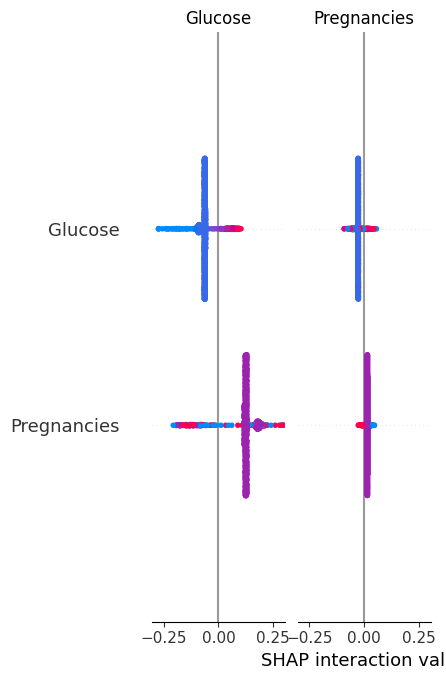

In [12]:
import shap

# Example: Diabetes
explainer = shap.TreeExplainer(multi_clf.estimators_[0])
shap_vals = explainer.shap_values(X_test)

shap.summary_plot(shap_vals, X_test, feature_names=X_test.columns)


In [ ]:
import joblib

joblib.dump(multi_clf, 'multi_disease_model.pkl')


['multi_disease_model.pkl']

In [13]:
def predict_diseases(input_df, threshold=0.4):
    df_copy = input_df.copy()

    # Encode categorical
    for col in categorical_cols:
        df_copy.loc[:, col] = le.fit_transform(df_copy[col])

    # Scale numeric
    df_copy.loc[:, numeric_cols] = scaler.transform(df_copy[numeric_cols])

    # Get probabilities
    probas = []
    for i, est in enumerate(multi_clf.estimators_):
        p = est.predict_proba(df_copy)[:,1]
        probas.append(p)
    probas = np.array(probas).T  # shape: (n_samples, n_diseases)

    # Apply threshold
    preds = (probas >= threshold).astype(int)

    results = pd.DataFrame(preds, columns=y.columns)
    results_proba = pd.DataFrame(probas, columns=[f"{col}_proba" for col in y.columns])

    return results, results_proba

# Example usage
sample_preds, sample_probas = predict_diseases(X_test.iloc[:5].copy(), threshold=0.4)
print("Sample binary predictions:\n", sample_preds)
print("\nSample probabilities:\n", sample_probas)


Sample binary predictions:
    Diabetes  HeartDisease  Stroke
0         0             0       0
1         0             0       0
2         0             0       0
3         0             0       0
4         0             0       0

Sample probabilities:
    Diabetes_proba  HeartDisease_proba  Stroke_proba
0             0.0            0.084837      0.038394
1             0.0            0.084837      0.060167
2             0.0            0.084837      0.022199
3             0.0            0.119837      0.015039
4             0.0            0.084837      0.039672


In [14]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV

# Base RandomForest
base_rf = RandomForestClassifier(
    n_estimators=200,
    max_depth=10,
    random_state=42,
    class_weight='balanced'
)

# Wrap base classifier with CalibratedClassifierCV
calibrated_rf = CalibratedClassifierCV(estimator=base_rf, cv=5)

# Wrap with MultiOutputClassifier for multi-disease
multi_calibrated = MultiOutputClassifier(calibrated_rf)

# Fit the multi-output calibrated model
multi_calibrated.fit(X_train, y_train)


MultiOutputClassifier(estimator=CalibratedClassifierCV(cv=5,
                                                       estimator=RandomForestClassifier(class_weight='balanced',
                                                                                        max_depth=10,
                                                                                        n_estimators=200,
                                                                                        random_state=42)))

In [15]:
# =========================
# 1️⃣ Predict on test set
# =========================
y_pred = multi_calibrated.predict(X_test)
y_proba = multi_calibrated.predict_proba(X_test)

# =========================
# 2️⃣ Convert probabilities to DataFrame
# =========================
proba_df = pd.DataFrame({
    'Diabetes_proba': y_proba[0][:, 1],       # probability of class 1
    'HeartDisease_proba': y_proba[1][:, 1],
    'Stroke_proba': y_proba[2][:, 1]
})

# =========================
# 3️⃣ Convert binary predictions to DataFrame
# =========================
pred_df = pd.DataFrame(y_pred, columns=y_train.columns)

# =========================
# 4️⃣ Inspect sample predictions
# =========================
print("Sample binary predictions:\n", pred_df.head())
print("\nSample probabilities:\n", proba_df.head())


Sample binary predictions:
    Diabetes  HeartDisease  Stroke
0         0             0       0
1         0             0       0
2         0             0       0
3         1             0       0
4         0             0       0

Sample probabilities:
    Diabetes_proba  HeartDisease_proba  Stroke_proba
0        0.003138            0.000619      0.057973
1        0.003138            0.000619      0.116366
2        0.003138            0.000619      0.010286
3        0.686663            0.000669      0.008104
4        0.003138            0.000619      0.042000


In [16]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score, classification_report

for i, disease in enumerate(y_train.columns):
    print(f"\n=== {disease} ===")

    # Binary predictions
    y_true = y_test[disease]
    y_hat = pred_df[disease]

    # Metrics
    print(classification_report(y_true, y_hat))
    print("Accuracy:", accuracy_score(y_true, y_hat))

    # ROC-AUC (using predicted probabilities)
    y_prob = proba_df.iloc[:, i]
    try:
        auc = roc_auc_score(y_true, y_prob)
        print("ROC-AUC:", auc)
    except ValueError:
        print("ROC-AUC: Not defined (single class present in y_true)")


=== Diabetes ===
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      1231
           1       0.60      0.50      0.55        66

    accuracy                           0.96      1297
   macro avg       0.79      0.74      0.76      1297
weighted avg       0.95      0.96      0.96      1297

Accuracy: 0.9575944487278335
ROC-AUC: 0.9793589838268961

=== HeartDisease ===
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1232
           1       0.92      1.00      0.96        65

    accuracy                           1.00      1297
   macro avg       0.96      1.00      0.98      1297
weighted avg       1.00      1.00      1.00      1297

Accuracy: 0.9953739398612182
ROC-AUC: 0.9997502497502497

=== Stroke ===
              precision    recall  f1-score   support

           0       0.95      1.00      0.98      1237
           1       0.00      0.00      0.00        60

    accuracy

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


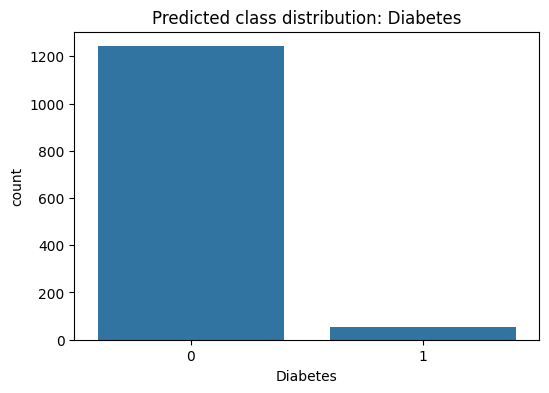

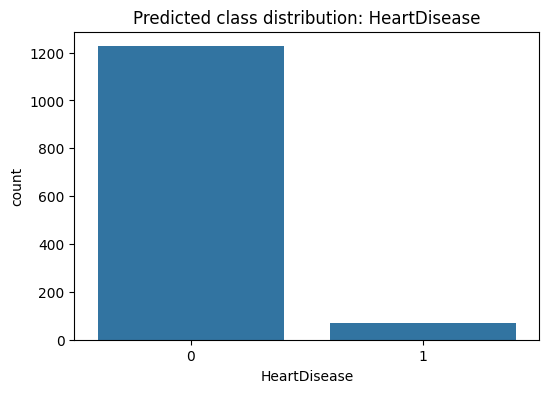

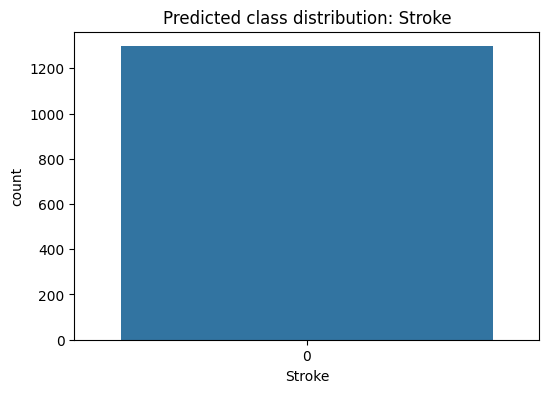

In [18]:
for disease in y_train.columns:
    plt.figure(figsize=(6,4))
    sns.countplot(x=disease, data=pred_df)  # use pred_df instead of combined_df
    plt.title(f'Predicted class distribution: {disease}')
    plt.show()


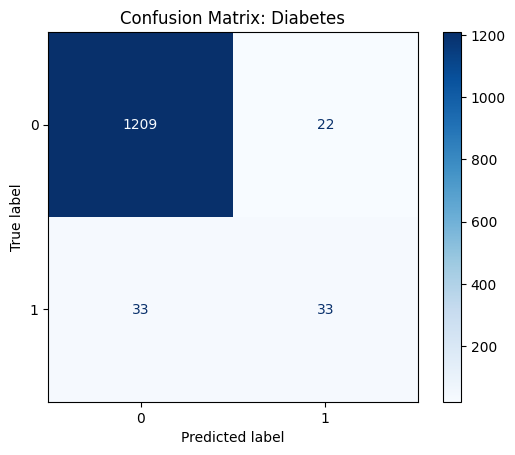

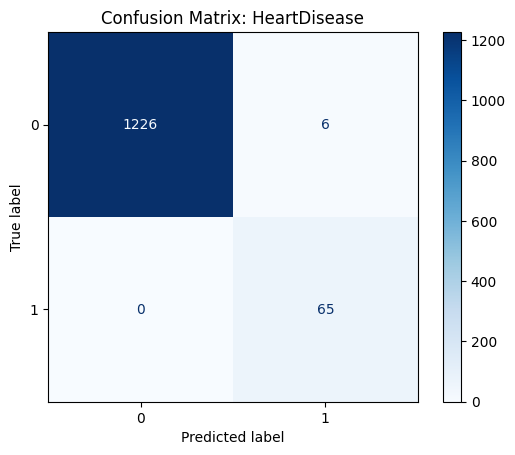

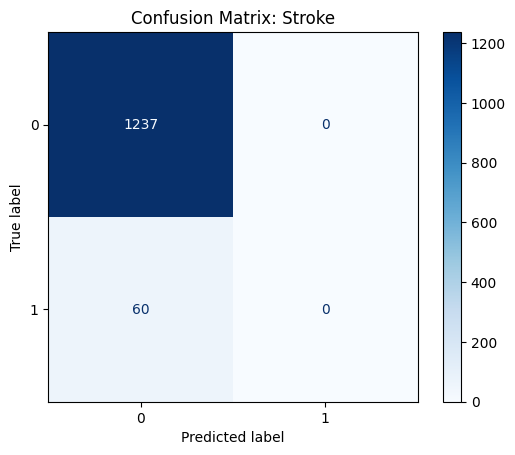

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

for i, disease in enumerate(y_train.columns):
    cm = confusion_matrix(y_test[disease], y_pred[:, i])
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap='Blues')
    plt.title(f'Confusion Matrix: {disease}')
    plt.show()
